In [1]:
import requests
import tarfile
import os

url = "https://downloads.wortschatz-leipzig.de/corpora/deu_mixed-typical_2011_10K.tar.gz"
filename = "deu_mixed-typical_2011_10K.tar.gz"
extracted_dir = "deu_mixed-typical_2011_10K"
text_file_name = "deu_mixed-typical_2011_10K-sentences.txt"

# 1. Datei herunterladen
print(f"Lade Datei von {url} herunter...")
response = requests.get(url, stream=True)
if response.status_code == 200:
  with open(filename, 'wb') as f:
    f.write(response.raw.read())
  print("Download abgeschlossen.")
else:
  print(f"Fehler beim Herunterladen: Statuscode {response.status_code}")

# 2. Datei entpacken
print(f"Entpacke Datei {filename}...")
if os.path.exists(filename):
  with tarfile.open(filename, "r:gz") as tar:
    tar.extractall(".")
  print("Entpacken abgeschlossen.")
else:
  print(f"Fehler: Datei {filename} nicht gefunden.")

# 3. Text extrahieren
print(f"Extrahiere Text aus {text_file_name}...")
full_text = ""
file_path = os.path.join(extracted_dir, text_file_name)

if os.path.exists(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
      # Zeilenaufbau: Zeilennummer + Tab + Text
      parts = line.strip().split('\t', 1)
      if len(parts) > 1:
        full_text += parts[1] + " " # Füge den Text und ein Leerzeichen hinzu
  print("Textextraktion abgeschlossen.")
else:
  print(f"Fehler: Textdatei {file_path} nicht gefunden. Bitte prüfen Sie den Dateinamen im Tar-Archiv.")

Lade Datei von https://downloads.wortschatz-leipzig.de/corpora/deu_mixed-typical_2011_10K.tar.gz herunter...
Download abgeschlossen.
Entpacke Datei deu_mixed-typical_2011_10K.tar.gz...
Entpacken abgeschlossen.
Extrahiere Text aus deu_mixed-typical_2011_10K-sentences.txt...
Textextraktion abgeschlossen.


In [2]:
import string
from collections import Counter

UNKNOWN_TOKEN = "<unk>"

def generate_word_alphabet_and_translation(corpus_text, max_vocab_size=1024, min_count=4):
  """
  Generiert ein wortbasiertes Alphabet und eine Übersetzungstabelle
  basierend auf einem gegebenen Textkorpus, optional begrenzt durch eine maximale Vokabulargröße.

  Args:
    corpus_text (str): Der Textkorpus.
    max_vocab_size (int, optional): Die maximale Größe des Vokabulars.
                                    Wenn None, wird kein Limit angewendet.

  Returns:
    tuple: Ein Tupel, das Folgendes enthält:
      - set: Das Alphabet (ein Set eindeutiger Wörter).
      - dict: Die Übersetzungstabelle (Wort zu Index).
  """
  # Einfache Worttokenisierung (kann durch komplexere Tokenizer ersetzt werden)
  words = corpus_text.lower().split()

  # Zähle die Häufigkeit der Wörter
  word_counts = Counter(words)
  # Wähle die am häufigsten vorkommenden Wörter aus
  most_common_words = [word for word, count in word_counts.most_common(max_vocab_size-1) if count >= min_count]
  alphabet = set(most_common_words)

  word_to_index = {word: i for i, word in enumerate(sorted(list(alphabet)))}
  word_to_index[UNKNOWN_TOKEN] = len(word_to_index)
  return words, alphabet, word_to_index

# Beispielaufruf mit einer maximalen Vokabulargröße von 1000
# Passen Sie 1000 an Ihre gewünschte Vokabulargröße an
words, alphabet, word_to_index = generate_word_alphabet_and_translation(full_text, max_vocab_size=2048, min_count=4)

print(f"Größe des Vokabulars: {len(word_to_index)}")
print(list(alphabet)[:10])

Größe des Vokabulars: 1879
['unterschiedliche', 'reihe', 'unterdessen', 'wo', 'investoren', 'läuft', 'tradition.', 'veranstaltung', 'offizielle', 'bedarf']


In [3]:
import numpy as np
import tensorflow as tf
import random

WINDOW_SIZE = 8

def create_bow_dataset(words, word_to_index, window_size):
  """
  Erstellt ein Dataset für das Training von Word2Vec mit Bag-of-Words-Kontexten.

  Args:
    words (str[]): Der gesamte Textkorpus als String-Array.
    word_to_index (dict): Die Abbildung von Wörtern zu Indizes.
    window_size (int): Die Größe des Kontextfensters auf jeder Seite des Zielworts.

  Returns:
  tf.data.Dataset: Ein TensorFlow Dataset mit Paaren von (Kontext-One-Hot-Vektor, Ziel-One-Hot-Vektor).
  """
  vocab_size = len(word_to_index)

  def window_generator(words, window_size):
    word_indices = np.array([word_to_index.get(word, -1) for word in words])

    word_collection = list(enumerate(word_indices))
    random.shuffle(word_collection)
    for i, target_index in word_collection:
      if target_index == -1:
        target_index = word_to_index[UNKNOWN_TOKEN]

      # Auswählen des fensters
      start = max(0, i - window_size)
      end = min(len(words), i + window_size + 1)
      context_indices = word_indices[start:end]

      # Entfernen des Target-Words
      context_indices = context_indices[context_indices != target_index]

      # Unbekannte Wörter sollen nicht im context sein.
      context_indices = context_indices[context_indices != -1]

      yield target_index, context_indices

  def generator():
    for target_index, context_indices in window_generator(words, window_size):
      # positive sampling
      for context_index in context_indices:
        yield np.array([target_index, context_index], dtype=np.int32), np.array([1], dtype=np.float32)

      # negative sampling für binäre Klassifizierung
      for i in range(len(context_indices)):
        negative_sample = -1
        while negative_sample == -1 or negative_sample in context_indices:
          word = random.choice(words) # Sample words - erhalten der Verteilung
          if word in word_to_index:
            negative_sample = word_to_index[word]
          else:
            negative_sample = word_to_index[UNKNOWN_TOKEN]

        yield np.array([target_index, negative_sample], dtype=np.int32), np.array([0], dtype=np.float32)

  dataset_size = sum(1 for _ in generator())
  print(f"Größe des Datasets: {dataset_size}")

  output_signature = (
    tf.TensorSpec(shape=(2,), dtype=tf.int32),
    tf.TensorSpec(shape=(1,), dtype=tf.float32)
  )

  dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature,
  )

  return dataset, dataset_size


# Erstelle das Dataset und erhalte die Größe
training_dataset, dataset_size = create_bow_dataset(words, word_to_index, WINDOW_SIZE)

# Cache and batch the datasets
BATCH_SIZE = 256
train_dataset = training_dataset.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

Größe des Datasets: 1343154


In [4]:
class SkipGramModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(SkipGramModel, self).__init__()
    self.input_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="word_embeddings")
    self.context_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="context_embeddings")
    self.flatten = tf.keras.layers.Flatten()
    self.dot = tf.keras.layers.Dot(axes=1)
    self.binary = tf.keras.layers.Dense(units=1, activation='sigmoid')

  def call(self, inputs):
    target = inputs[:,0]
    context = inputs[:,1]

    # inputs is the Bag-of-Words vector
    target_embeddings = self.input_embedding(target)
    target_embeddings = self.flatten(target_embeddings)

    context_embeddings = self.context_embedding(context)
    context_embeddings = self.flatten(context_embeddings)

    embeddings_sum = self.dot([target_embeddings, context_embeddings])

    output = self.binary(embeddings_sum)
    return output

EMBEDDING_DIM = 128 # Beispielwert für die Größe der Einbettung

# Definition des Modells unter Verwendung der benutzerdefinierten Klasse
model = SkipGramModel(len(word_to_index), EMBEDDING_DIM)

# Modell kompilieren
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Klassifikation, richtiges Wort.
              metrics=['accuracy'])

# Trainiere das Modell einmal kurz, um die summary zu ermöglichen
for x,y in train_dataset.take(1):
    model(x)
    break # Nur einmal aufrufen, um die Gewichte zu initialisieren

model.summary()

Model: "skip_gram_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embeddings (Embedding)     │ (256, 128)             │       240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context_embeddings (Embedding)  │ (256, 128)             │       240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (256, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot (Dot)                       │ (256, 1)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 1)               │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,026 (1.83 MB)

 Trainable params: 481,026 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Training des Modells
EPOCHS = 3  # Sie können die Anzahl der Epochen anpassen

# Berechnen wie viel Schritte pro epoche notwendig sind.
train_steps_per_epoch = dataset_size // BATCH_SIZE

if dataset_size % BATCH_SIZE != 0:
    train_steps_per_epoch += 1

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,
)

Epoch 1/3
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 504s 96ms/step - accuracy: 0.6690 - loss: 0.5630
Epoch 2/3
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 498s 95ms/step - accuracy: 0.6899 - loss: 0.5320
Epoch 3/3
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 498s 95ms/step - accuracy: 0.7035 - loss: 0.5196


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


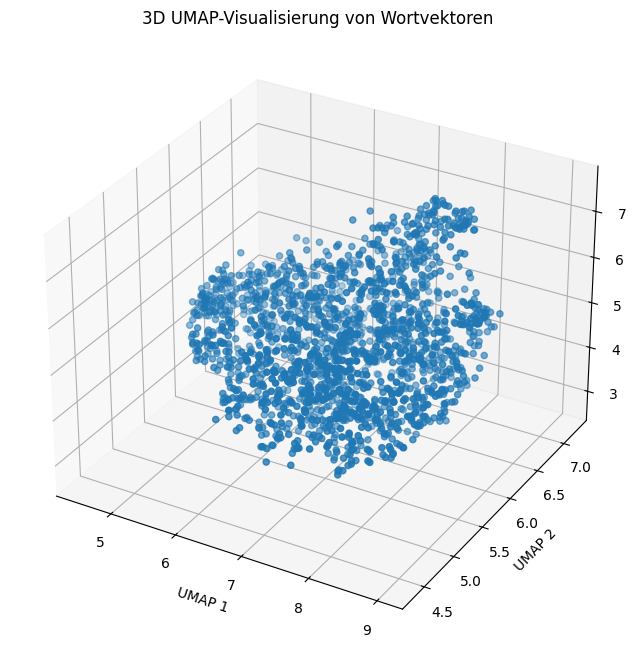

In [6]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Vektoren und die entsprechenden Wörter aus dem Word2Vec-Modell
word_vectors = model.get_layer('word_embeddings').get_weights()[0]

# Reduziere die Dimensionen der Vektoren mit UMAP auf 3D
reducer = umap.UMAP(n_components=3) # Auf 3 Komponenten für 3D
embedding_3d = reducer.fit_transform(word_vectors)

# Erstelle einen Pandas DataFrame für einfachere Handhabung
df_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_3d['word'] = list(alphabet)+["Unknown"]

# Wähle einige der wichtigsten Wortgruppen aus (basierend auf Häufigkeit oder Relevanz)
# Hier wählen wir einfach die ersten 100 Wörter im Vokabular als Beispiel
num_words_to_plot = 4096 # Wählen Sie eine angemessene Anzahl von Wörtern
df_plot = df_3d.head(num_words_to_plot)

# Plotten der 3D-Einbettungen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Punkt für jedes Wort
ax.scatter(df_plot['UMAP1'], df_plot['UMAP2'], df_plot['UMAP3'])

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D UMAP-Visualisierung von Wortvektoren')

plt.show()